In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [23]:
df = pd.read_excel("C:/Users/Shreya/Downloads/Clustering/Clustering/EastWestAirlines.xlsx", sheet_name='data')
print("Shape of data:", df.shape)
print(df.head())

Shape of data: (3999, 12)
   ID#  Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1    28143           0          1          1          1          174   
1    2    19244           0          1          1          1          215   
2    3    41354           0          1          1          1         4123   
3    4    14776           0          1          1          1          500   
4    5    97752           0          4          1          1        43300   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  
0            1                  0                0               7000       0  
1            2                  0                0               6968       0  
2            4                  0                0               7034       0  
3            1                  0                0               6952       0  
4           26               2077                4               6935       1  


In [25]:
# Drop ID column (non-numeric)
df = df.drop('ID#', axis=1)

# Check missing values
print("\nMissing values:\n", df.isnull().sum())

# Fill or drop missing values
df = df.dropna()  # dataset usually has no missing, but this is safe


Missing values:
 Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


In [27]:
# Handle outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
print("\nShape after outlier removal:", df_clean.shape)


Shape after outlier removal: (2875, 11)


In [29]:
# Scale the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

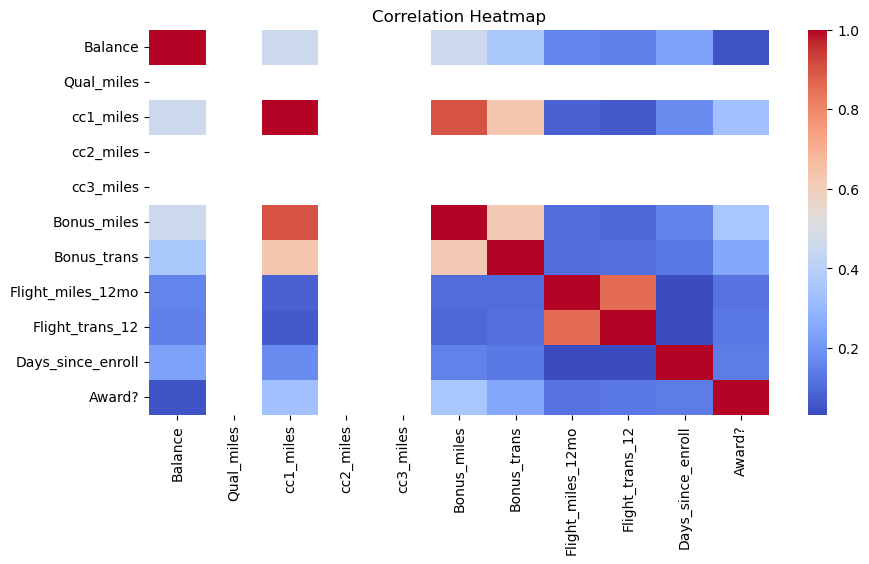

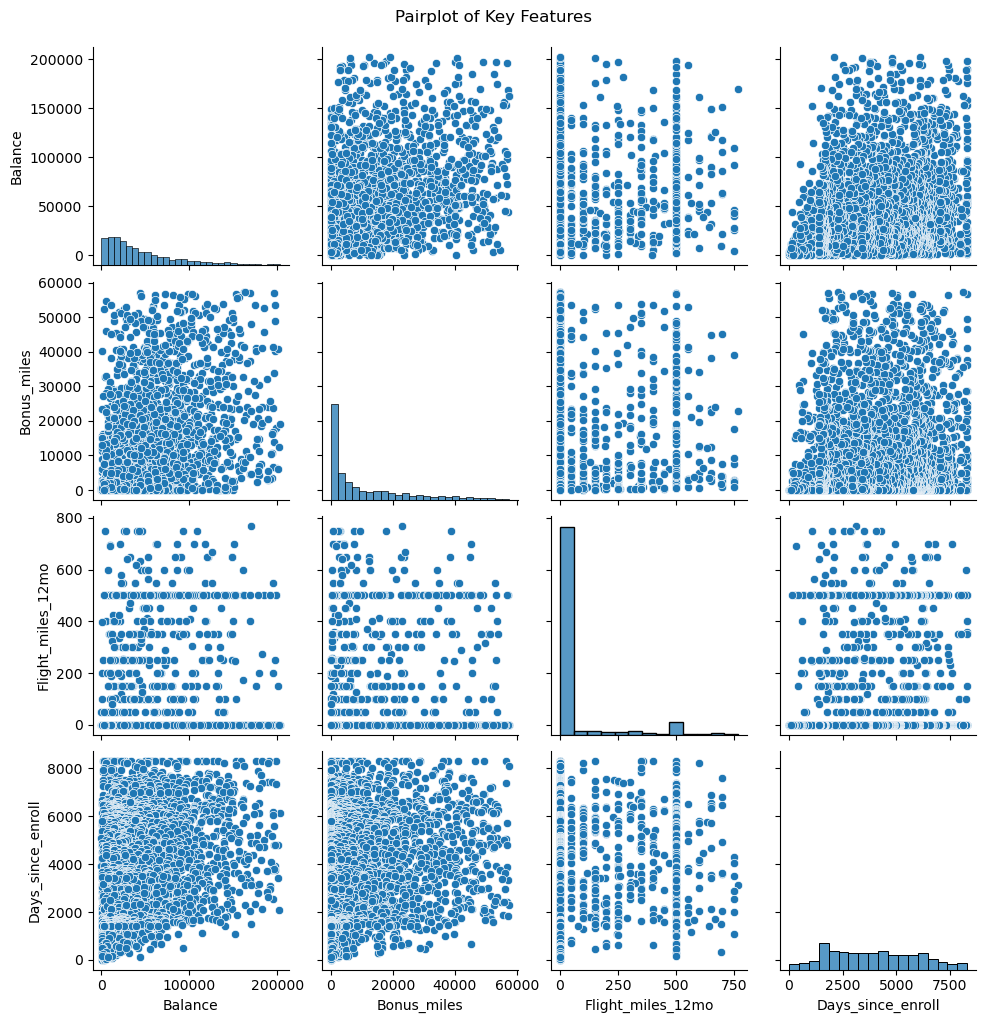

In [33]:
#EXPLORATORY DATA ANALYSIS (EDA)
plt.figure(figsize=(10,5))
sns.heatmap(df_scaled.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

sns.pairplot(df_clean[['Balance', 'Bonus_miles', 'Flight_miles_12mo', 'Days_since_enroll']])
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

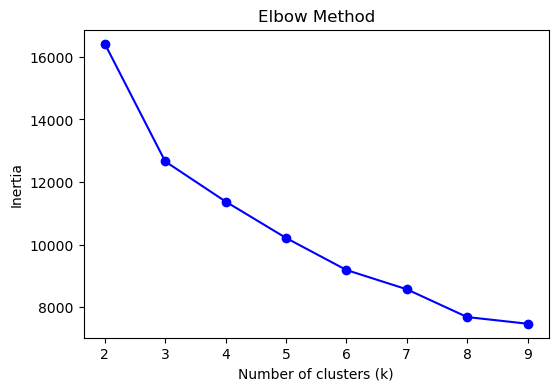

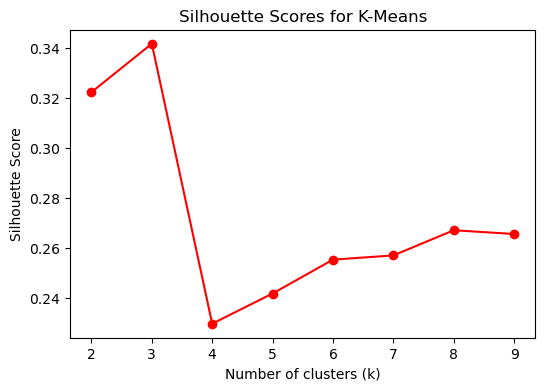

C:\Users\Shreya\AppData\Local\Temp\ipykernel_2376\59681834.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['KMeans_Cluster'] = kmeans_labels



K-Means Silhouette Score: 0.22962827467448732


In [35]:
# K-MEANS CLUSTERING
inertia = []
sil_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Elbow Plot
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Silhouette Plot
plt.figure(figsize=(6,4))
plt.plot(K, sil_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means')
plt.show()

# Choose k=4 for example
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
df_clean['KMeans_Cluster'] = kmeans_labels
print("\nK-Means Silhouette Score:", silhouette_score(df_scaled, kmeans_labels))


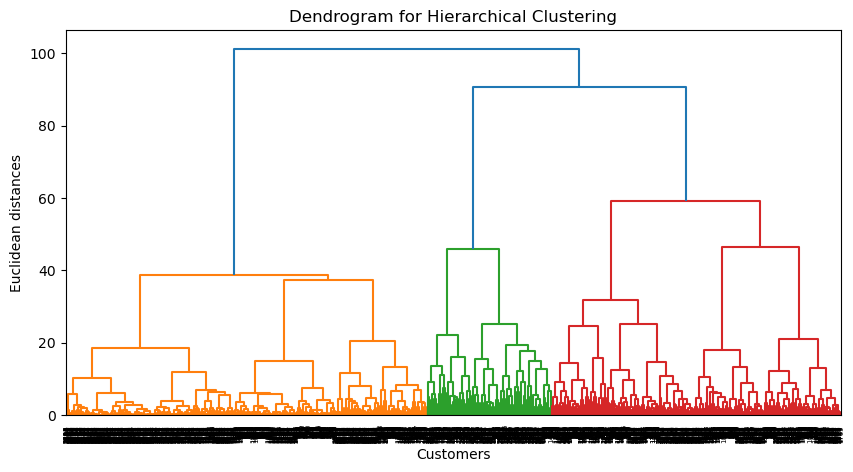

C:\Users\Shreya\AppData\Local\Temp\ipykernel_2376\2025413119.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Hier_Cluster'] = h_clusters


In [37]:
#HIERARCHICAL CLUSTERING
Z = linkage(df_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customers")
plt.ylabel("Euclidean distances")
plt.show()

h_clusters = fcluster(Z, t=4, criterion='maxclust')
df_clean['Hier_Cluster'] = h_clusters

In [39]:
#DBSCAN CLUSTERING
dbscan = DBSCAN(eps=1.5, min_samples=10)
db_labels = dbscan.fit_predict(df_scaled)
df_clean['DBSCAN_Cluster'] = db_labels

# Evaluate DBSCAN (ignore noise points labeled -1)
mask = db_labels != -1
if sum(mask) > 1:
    print("\nDBSCAN Silhouette Score:", silhouette_score(df_scaled[mask], db_labels[mask]))
else:
    print("\nDBSCAN produced mostly noise; silhouette not meaningful.")

C:\Users\Shreya\AppData\Local\Temp\ipykernel_2376\207943124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['DBSCAN_Cluster'] = db_labels



DBSCAN Silhouette Score: 0.26561729508328463


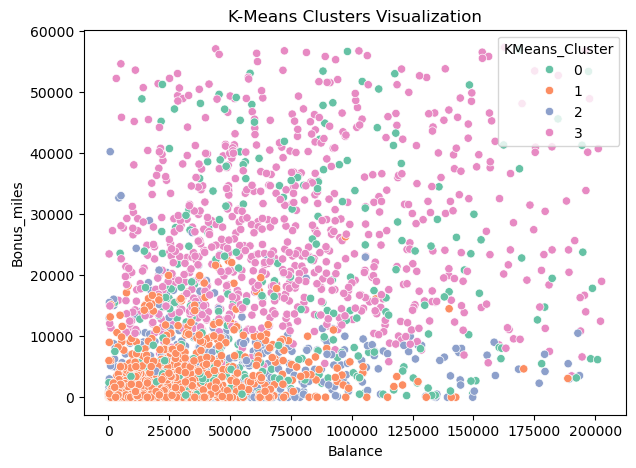

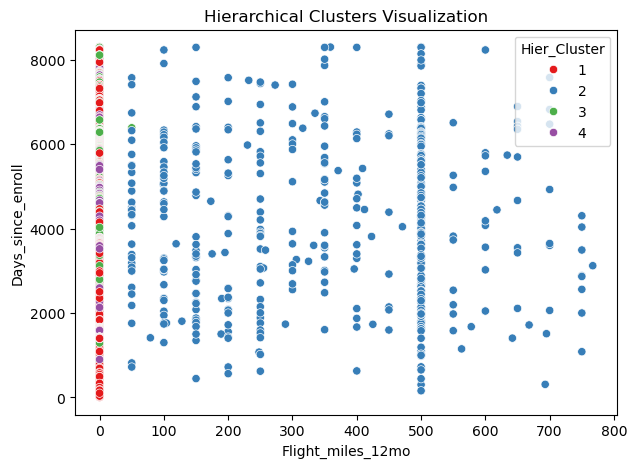

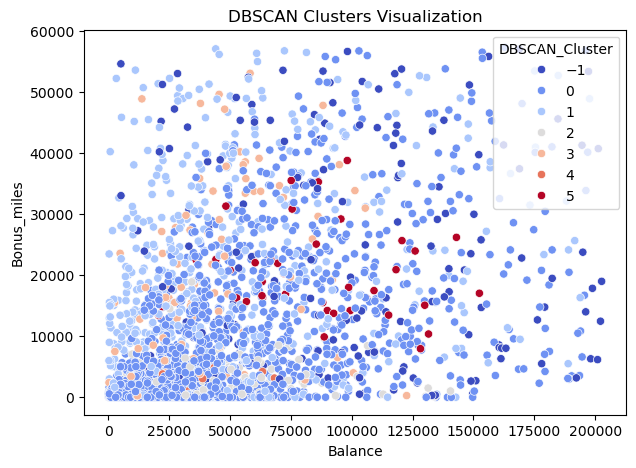

In [41]:
#VISUALIZATION OF CLUSTERS
plt.figure(figsize=(7,5))
sns.scatterplot(x='Balance', y='Bonus_miles', hue='KMeans_Cluster', data=df_clean, palette='Set2')
plt.title("K-Means Clusters Visualization")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x='Flight_miles_12mo', y='Days_since_enroll', hue='Hier_Cluster', data=df_clean, palette='Set1')
plt.title("Hierarchical Clusters Visualization")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x='Balance', y='Bonus_miles', hue='DBSCAN_Cluster', data=df_clean, palette='coolwarm')
plt.title("DBSCAN Clusters Visualization")
plt.show()

In [43]:
#CLUSTER ANALYSIS
cluster_summary = df_clean.groupby('KMeans_Cluster').mean()
print("\nK-Means Cluster Summary:\n", cluster_summary)


K-Means Cluster Summary:
                      Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                              
0               65113.991501         0.0   2.065156        1.0        1.0   
1               25552.377339         0.0   1.092516        1.0        1.0   
2               36146.795071         0.0   1.138781        1.0        1.0   
3               75069.773131         0.0   3.299113        1.0        1.0   

                 Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Cluster                                                                  
0               14463.011331    11.756374         428.084986         1.308782   
1                2772.070686     5.465696           4.810811         0.038462   
2                3479.610895     6.156939           4.203632         0.036316   
3               26368.466413    16.259823           6.510773         0.055767   

                Days_si